In [1]:
import pandas as pd
import numpy as np

# Load custom modules
from nets import *
from sampling import *
from model_data import *
from preprocess import *
from model import *
from metrics import gini_normalized


# Others
from tqdm import tqdm
from torch.autograd import Variable as V
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys

In [3]:
sys.path.append('../../../Desktop/FASTAI/fastai/')

In [4]:
from fastai import column_data

### LOAD DATA

For fast iterations and experimentaions we will work with a random subsample.

In [5]:
train = pd.read_csv('./data/Porto_Seguro/train.csv')

In [6]:
train.shape

(595212, 59)

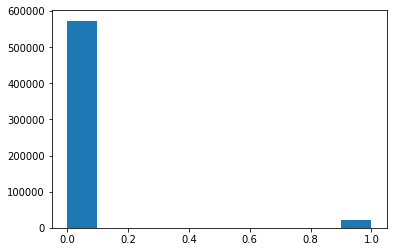

In [7]:
plot = plt.hist(train.target)

In [57]:
sampledata = subsample(train, 0.25)

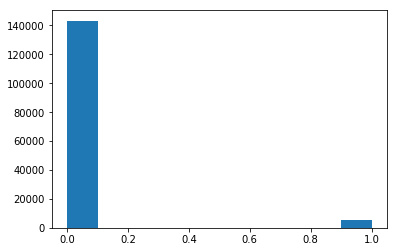

In [58]:
plot = plt.hist(sampledata.target)

In [59]:
# Get ohe for cats
cats = [c for c in sampledata.columns if 'cat' in c]
sampledata = num_df(sampledata, cats)

### SIMPLENET

* Simple Fully Connected Net
* OHE data 
* Normalized data 

In [60]:
# Normalize data by rankgauss, ignore id and target
sampledata = rankgauss(sampledata, exclude=['id', 'target'])

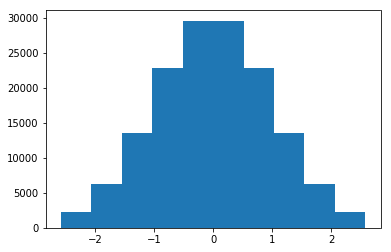

In [61]:
plot = plt.hist(sampledata.ps_car_01_cat)

In [62]:
# Do 5 fold cv split
cv = kfold_cv_idx(sampledata, 5)

In [63]:
# Create model data
modeldata = SimpleColumnModelData.from_dataframe(dataframe=sampledata.drop('id', 1), bs=256, cv=cv, target='target', test=None)

In [64]:
# init simple net
snet = SimpleNet([241, 500, 1000, 2])

In [65]:
model = snet
data = modeldata
epochs = 5
optimizer = Adam(snet.parameters())
criterion = nn.NLLLoss()

In [66]:
def fit_cv(model, data, epochs, optimizer, crit, metric=None):
    cv_trn_losses = []
    cv_val_losses = []
    metric_scores = []
    for cv_pair in tqdm(data.cv_dls):

        # Get fold train and validation
        trn_dl = cv_pair[0]
        val_dl = cv_pair[1]

        # Tranining
        alpha = 0.98
        smooth_loss, batch_num = 0., 0
        for epoch in range(epochs):
            for (x, y) in iter(trn_dl):
                batch_num += 1
                #Calculate loss
                outputs, labels = model(V(x)), V(y)
                loss = criterion(outputs, labels.squeeze(-1))
                smooth_loss = (alpha)*smooth_loss + (1 - alpha)*loss.data

                #Update Weights
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        # final training loss - debias loss
        smooth_loss = smooth_loss / (1 - alpha**batch_num)


        # Validation 
        val_loss = 0
        num_obs = 0
        val_true = []
        val_preds = []
        for (x, y) in iter(val_dl):
            outputs, labels = model(V(x)), V(y)
            loss = criterion(outputs, labels.squeeze(-1))
            n = len(labels)
            num_obs += n
            val_loss += loss.data[0]*n
            
            # Collect data for custom validation
            if metric: 
                val_true += list(labels.data.numpy())
                val_preds += list(outputs.data.numpy())   


        # Collect Aggreagated losses
        cv_trn_loss = smooth_loss[0]
        cv_val_loss = val_loss/num_obs
        cv_trn_losses.append(cv_trn_loss)
        cv_val_losses.append(cv_val_loss)
        
        # return val_true, val_preds
        #return (val_true, val_preds)
        # Custom validation
        if metric:
            metric_score = metric(val_true, val_preds)
            metric_scores.append(metric_score)
        
    trn_loss_avg = round(np.mean(cv_trn_losses), 4)
    trn_loss_std = round(np.std(cv_trn_losses), 4)
    val_loss_avg = round(np.mean(cv_val_losses), 4)
    val_loss_std = round(np.std(cv_val_losses), 4)

    print(f'training loss: {trn_loss_avg} +/- {trn_loss_std}, validation loss:  {val_loss_avg} +/- {val_loss_std}')
    if metric:
        custom_avg = np.mean(metric_scores)
        custom_std = np.std(metric_scores)
        print(f'{metric_scores}')
        print(f'custom mean: {custom_avg} +/- {custom_std}')

In [68]:
# re-init model
model = snet
fit_cv(model, data, 5, optimizer, criterion, metric=gini_normalized)

100%|██████████| 5/5 [04:33<00:00, 54.66s/it]

training loss: 0.0421 +/- 0.0348, validation loss:  0.0908 +/- 0.0574
[0.31240225955476697, 0.72848274467944085, 0.94735964771218495, 0.98711184437210919, 0.99131182335827017]
custom mean: 0.7933336639353544 +/- 0.25921805336361375
